https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [72]:
df = pd.read_csv('../data/train.csv')

In [73]:
df.shape

(414, 8)

<Figure size 720x720 with 0 Axes>

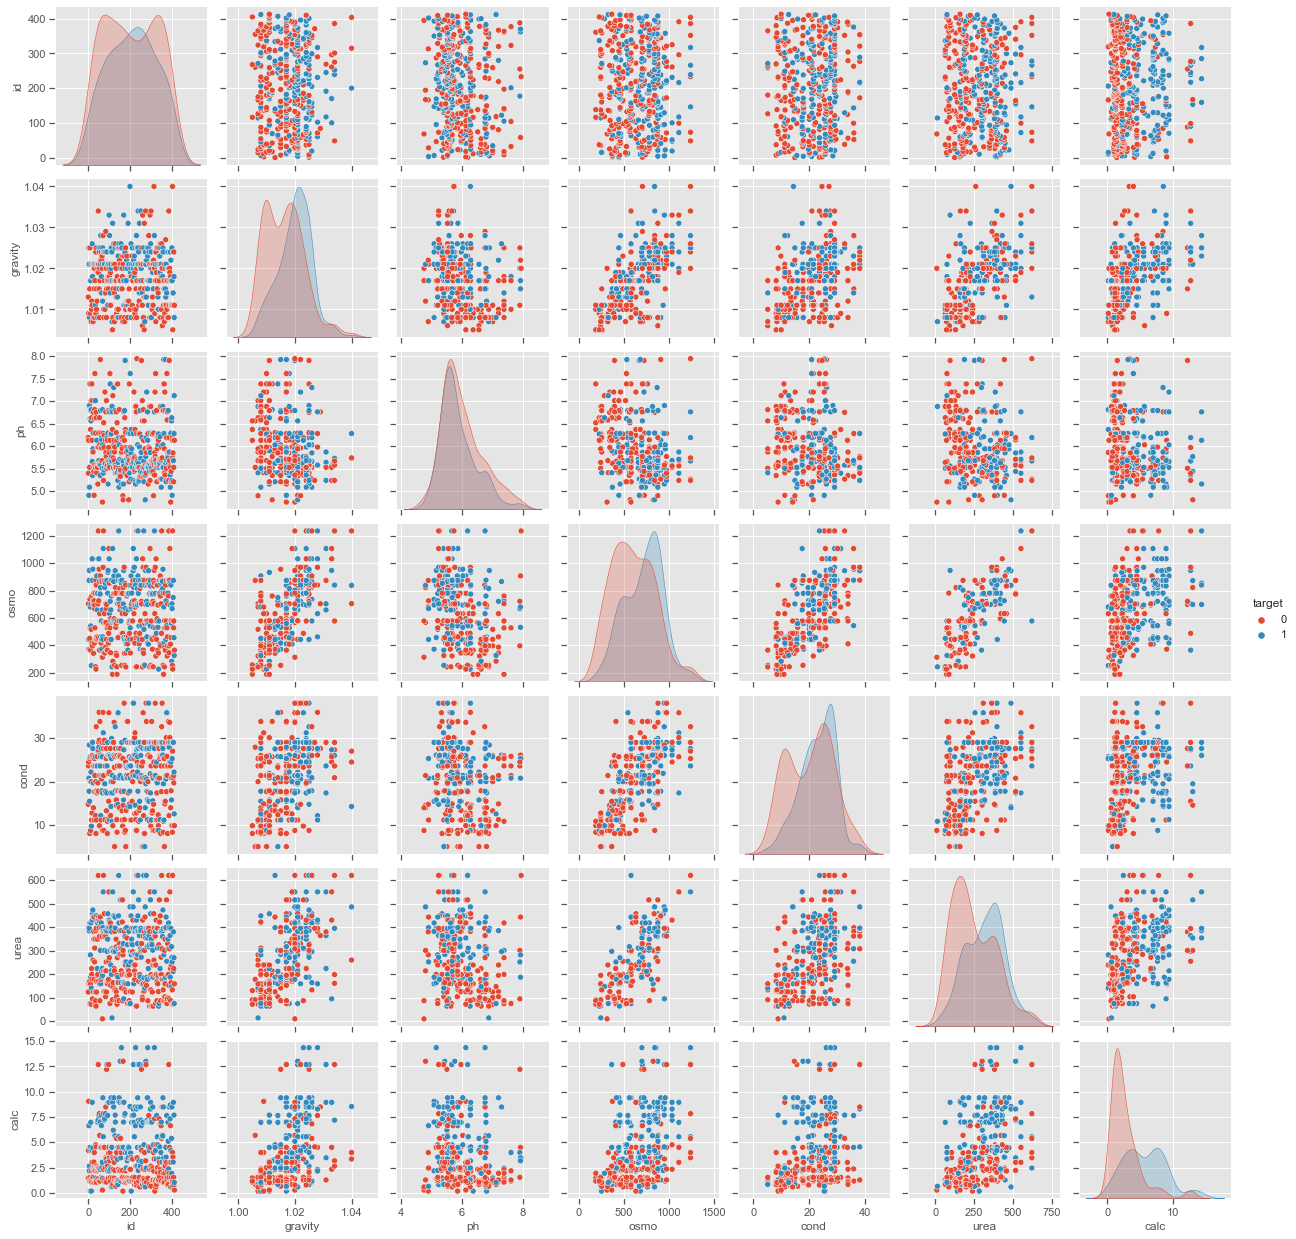

In [74]:
plt.figure(figsize=(10,10))

sns.pairplot(df_train, hue="target");

In [75]:
df_train.isna().sum()

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

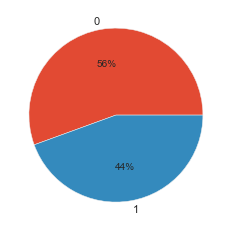

In [76]:
plt.pie(df_train['target'].value_counts(), labels=[0 , 1], autopct='%.0f%%');

In [77]:
from sklearn.model_selection import train_test_split

target = df_train['target']
features = df_train.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2)

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold

skf = StratifiedKFold(n_splits=3)

rf = RandomForestClassifier(n_estimators=50,
                            max_depth=5,
                            random_state=2049,
                            class_weight='balanced')

rf.fit(X_train, y_train)

print(classification_report(y_pred=rf.predict(X_test), y_true=y_test))

cv_results = cross_validate(rf, X=features, y=target, cv=skf ,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')



              precision    recall  f1-score   support

           0       0.71      0.73      0.72        44
           1       0.68      0.67      0.68        39

    accuracy                           0.70        83
   macro avg       0.70      0.70      0.70        83
weighted avg       0.70      0.70      0.70        83

10 Fold Cross validation mean f1 : 0.6566734417344174


In [79]:
from xgboost import XGBClassifier

skf = StratifiedKFold(n_splits=3)

scale_pos_weight = (target == False).sum()/(target == True).sum()
xgb = XGBClassifier(objective='binary:logistic',
                    scale_pos_weight=scale_pos_weight,
                    n_estimators=100)

xgb.fit(X_train, y_train)
print(classification_report(y_true=y_test, y_pred=rf.predict(X_test)))

cv_results = cross_validate(xgb, X=features, y=target, cv=skf,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.71      0.73      0.72        44
           1       0.68      0.67      0.68        39

    accuracy                           0.70        83
   macro avg       0.70      0.70      0.70        83
weighted avg       0.70      0.70      0.70        83

10 Fold Cross validation mean f1 : 0.6467908099487047
